In [2]:
import sys
# sys.path.append(r"Y:\Users\Yingyue\Gates_Lab_Suite-master")
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
import os
from SPAM import *
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import pickle
import uuid

In [3]:
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc

In [4]:
def state_init_bell_pairs(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))

        
#should we set_mapping in this function? need to think about if it takes mapping into account   
def add_pauli_twirl(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        q_index+=1
    return pauliLayer

def add_pauli_twirl_wSE(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        
        if (q_index==(int(n/2)-1)):
            for i in range (n):
                qc.Add_Gate(Quantum_Gate("SKAX",n+i,angle=1))
        q_index+=1
    return pauliLayer
    
def add_clifford_layer(qc,n,clifford):
    if (clifford=="CNOT"):
        for i in range (floor(n/2)):
            qc.Add_Gate(Quantum_Gate("CNOT",2*i,2*i+1))
            
def bell_measurement(qc,n):
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("SKAX",int(i+n),angle=1))
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("HAD",i))

def map_statepop_2_ibm_mapping(counts,n):
    counts_ibm_mapping=[0 for i in range (2**(2*n))]
    idx_ibm_mapping=[]
    counts_ibm_mapping_dic={}
    if len(str((2*n)))<2:
        f="00"+str(2*n)+"b"
    elif len(str((2*n)))<3:
        f="0"+str(2*n)+"b"
    else:
        raise ValueError("n is too big")
    for gates_idx in range (2**(2*n)):
        gates_idx_str=format(gates_idx,f)
        ibm_idx=0
        for i in range (2*n):
            ibm_idx+=2**(i)*int(gates_idx_str[i])
        ibm_idx_str=format(ibm_idx,f)
#         idx_ibm_mapping.append(ibm_idx_str)
        counts_ibm_mapping[ibm_idx]=counts[gates_idx]
        counts_ibm_mapping_dic[ibm_idx_str]=counts[gates_idx]
    return counts_ibm_mapping, counts_ibm_mapping_dic
        
        
#for qiskit
def prepare_bell_state_1q(circuit,index1,index2):
	circuit.h([index1])
	circuit.cx([index1],[index2])
        
def bell_measurement_1q(circuit,index1,index2): 
	# info qubit at index1
	circuit.cx([index1],[index2])
	circuit.h([index1])

def pauli_gate_1q(circuit,index,pauli=None): #For stabilizer simulator to work, cannot use Pauli class
	if pauli == 'I':
		circuit.id([index])
	elif pauli == 'Z':
		circuit.z([index])
	elif pauli == 'X':
		circuit.x([index])
	elif pauli == 'Y':
		circuit.y([index])
	else:
		assert 1==0

    
    
    

In [5]:
## Additional functions

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    

In [34]:
Set_Mapping([1,3,4,5,2])
nqubit=2
C=20
results_d2=np.zeros((C,2**(2*nqubit)))
results_d4=np.zeros((C,2**(2*nqubit)))
results_d8=np.zeros((C,2**(2*nqubit)))

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/XX/d=2.txt", 'r')
Lines= file.readlines()
c_d2=[]
count = 0
for line in Lines:
    c_d2.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/XX/d=4.txt", 'r')
Lines= file.readlines()
c_d4=[]
count = 0
for line in Lines:
    c_d4.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/XX/d=8.txt", 'r')
Lines= file.readlines()
c_d8=[]
count = 0
for line in Lines:
    c_d8.append(line)
    count += 1
print (count)
count=0


20
20
20


In [1]:
filenames_d2=[]
filenames_d4=[]
filenames_d8=[]
filenames=[]

paf_data_d2="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0703/2023-07-03 EAB 01+10 d=2/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d2):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d2.append(filenames[i])
            break
print (filenames_d2)



paf_data_d4="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0703/2023-07-03 EAB 01+10 d=4/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d4):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d4.append(filenames[i])
            break
print (filenames_d4)

paf_data_d8="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0703/2023-07-03 EAB__d=8/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d8 ):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d8.append(filenames[i])
            break
print (filenames_d8)

NameError: name 'os' is not defined

In [24]:
a=Quantum_State(5)
a_s=Quantum_State(5)
b_c=Quantum_Circuit(5,"qc")

spam1=SPAM_Operator(5)
spam1.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0516 FTXX 13452/spam/spam.csv")

# spam2=SPAM_Operator(5)
# spam2.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0424/SPAM1/SPAM1.csv")


2023-07-03-171416_Line_001.txt
counts: [13, 70, 154, 3384, 6, 63, 16, 272, 0, 0, 0, 20, 0, 0, 0, 2]
counts_ibm_mapping_dic: {'0000': 13, '1000': 70, '0100': 154, '1100': 3384, '0010': 6, '1010': 63, '0110': 16, '1110': 272, '0001': 0, '1001': 0, '0101': 0, '1101': 20, '0011': 0, '1011': 0, '0111': 0, '1111': 2}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



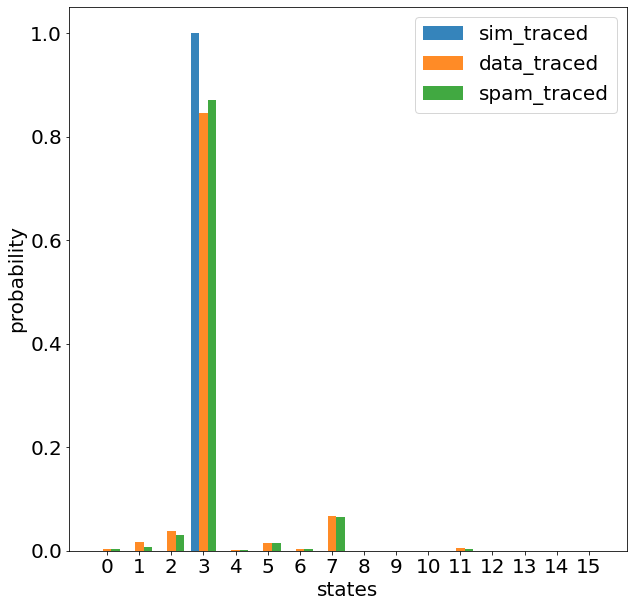

2023-07-03-171452_Line_002.txt
counts: [375, 15, 53, 25, 3286, 68, 123, 10, 3, 1, 0, 0, 39, 2, 0, 0]
counts_ibm_mapping_dic: {'0000': 375, '1000': 15, '0100': 53, '1100': 25, '0010': 3286, '1010': 68, '0110': 123, '1110': 10, '0001': 3, '1001': 1, '0101': 0, '1101': 0, '0011': 39, '1011': 2, '0111': 0, '1111': 0}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:RY+21:XA230.2500+:RX+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



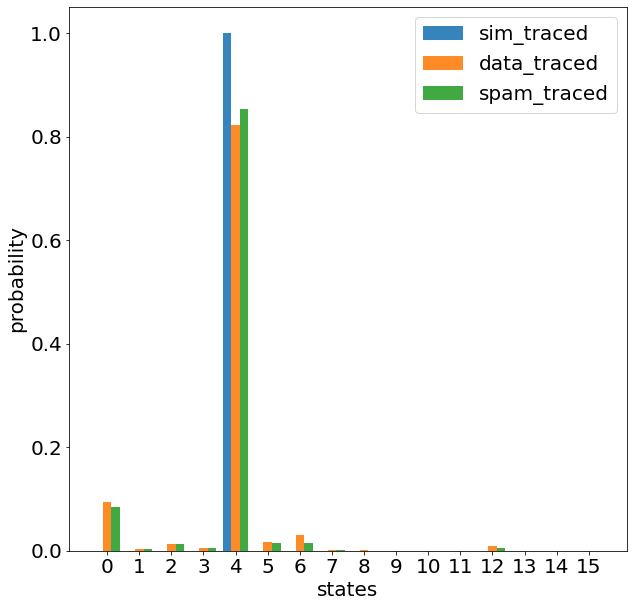

2023-07-03-171528_Line_003.txt
counts: [563, 30, 52, 20, 2952, 90, 131, 138, 2, 1, 0, 0, 19, 1, 1, 0]
counts_ibm_mapping_dic: {'0000': 563, '1000': 30, '0100': 52, '1100': 20, '0010': 2952, '1010': 90, '0110': 131, '1110': 138, '0001': 2, '1001': 1, '0101': 0, '1101': 0, '0011': 19, '1011': 1, '0111': 1, '1111': 0}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



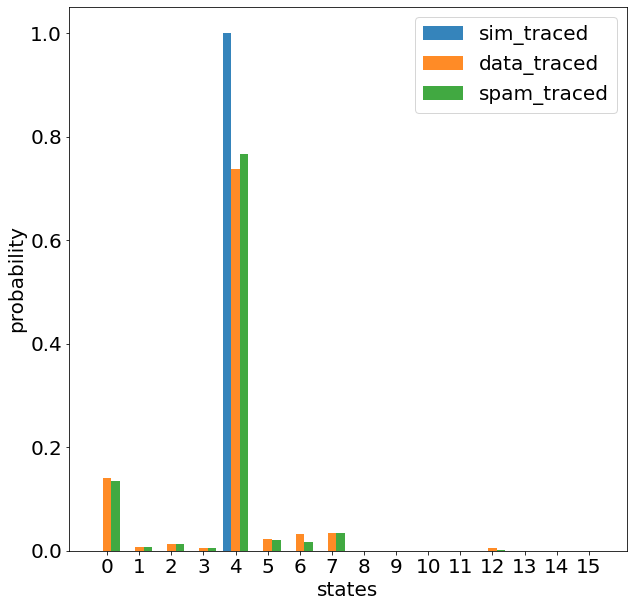

2023-07-03-171606_Line_004.txt
counts: [106, 9, 3352, 154, 61, 4, 243, 16, 2, 0, 45, 0, 2, 0, 6, 0]
counts_ibm_mapping_dic: {'0000': 106, '1000': 9, '0100': 3352, '1100': 154, '0010': 61, '1010': 4, '0110': 243, '1110': 16, '0001': 2, '1001': 0, '0101': 45, '1101': 0, '0011': 2, '1011': 0, '0111': 6, '1111': 0}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



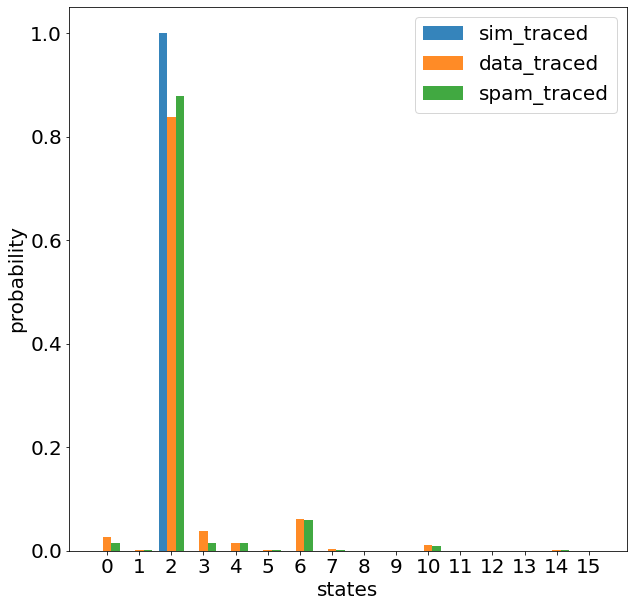

2023-07-03-171803_Line_005.txt
counts: [19, 106, 136, 3419, 11, 54, 10, 215, 0, 1, 0, 25, 0, 0, 1, 3]
counts_ibm_mapping_dic: {'0000': 19, '1000': 106, '0100': 136, '1100': 3419, '0010': 11, '1010': 54, '0110': 10, '1110': 215, '0001': 0, '1001': 1, '0101': 0, '1101': 25, '0011': 0, '1011': 0, '0111': 1, '1111': 3}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



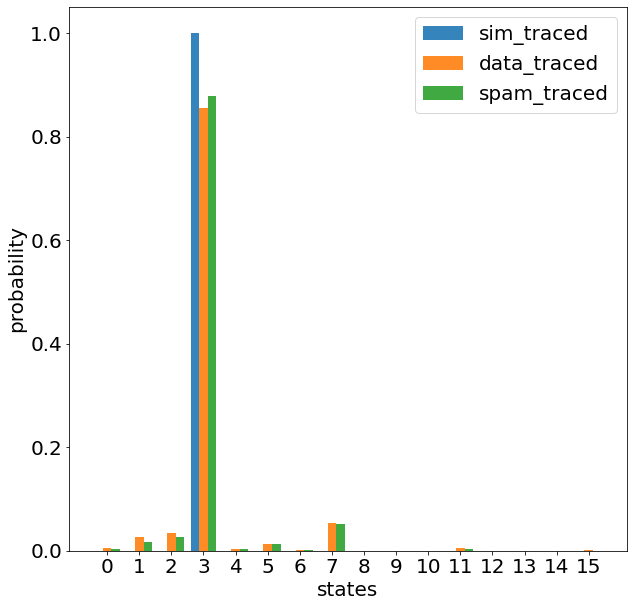

2023-07-03-171839_Line_006.txt
counts: [45, 25, 146, 8, 98, 12, 3486, 146, 1, 0, 1, 0, 2, 0, 29, 1]
counts_ibm_mapping_dic: {'0000': 45, '1000': 25, '0100': 146, '1100': 8, '0010': 98, '1010': 12, '0110': 3486, '1110': 146, '0001': 1, '1001': 0, '0101': 1, '1101': 0, '0011': 2, '1011': 0, '0111': 29, '1111': 1}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



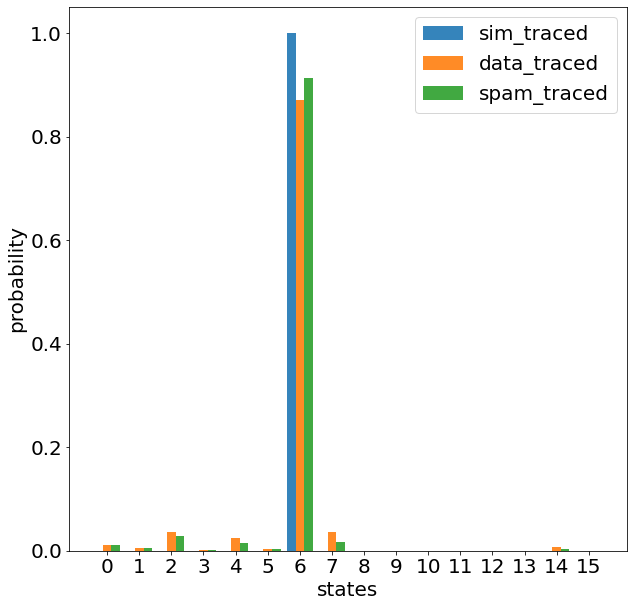

2023-07-03-171918_Line_007.txt
counts: [17, 73, 24, 257, 17, 101, 158, 3325, 0, 0, 0, 1, 1, 0, 1, 25]
counts_ibm_mapping_dic: {'0000': 17, '1000': 73, '0100': 24, '1100': 257, '0010': 17, '1010': 101, '0110': 158, '1110': 3325, '0001': 0, '1001': 0, '0101': 0, '1101': 1, '0011': 1, '1011': 0, '0111': 1, '1111': 25}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



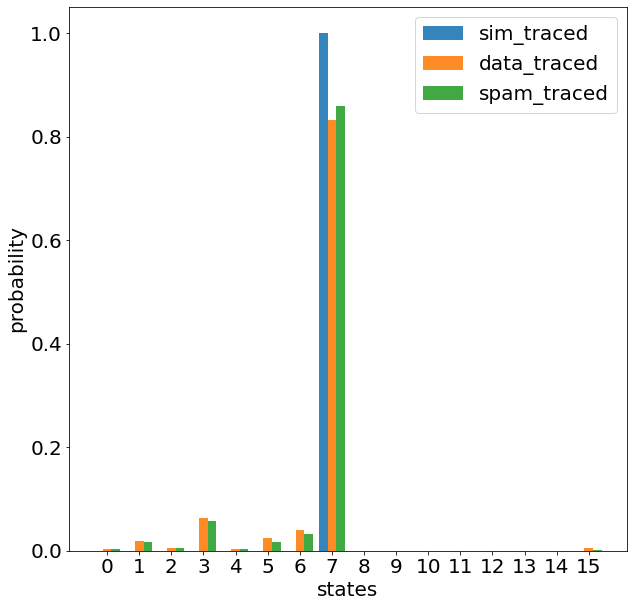

2023-07-03-171955_Line_008.txt
counts: [3026, 101, 98, 72, 507, 33, 86, 38, 25, 1, 1, 3, 7, 0, 0, 2]
counts_ibm_mapping_dic: {'0000': 3026, '1000': 101, '0100': 98, '1100': 72, '0010': 507, '1010': 33, '0110': 86, '1110': 38, '0001': 25, '1001': 1, '0101': 1, '1101': 3, '0011': 7, '1011': 0, '0111': 0, '1111': 2}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:RX+21:XA230.2500+:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



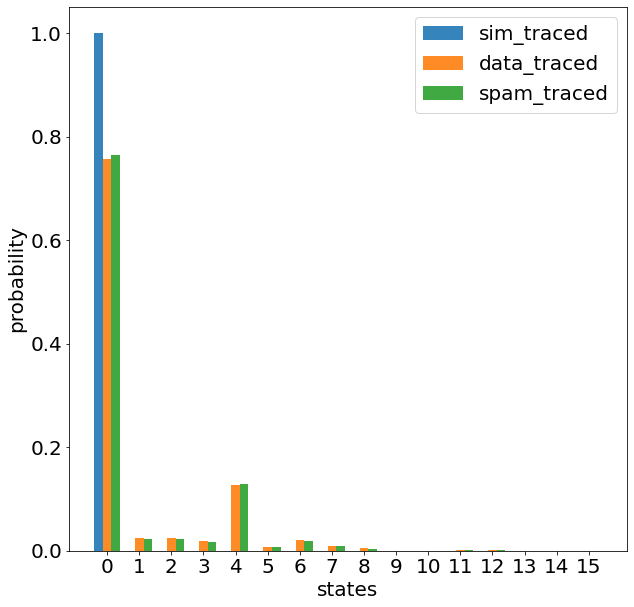

2023-07-03-172151_Line_009.txt
counts: [2975, 100, 75, 218, 480, 17, 63, 36, 30, 1, 2, 1, 1, 0, 0, 1]
counts_ibm_mapping_dic: {'0000': 2975, '1000': 100, '0100': 75, '1100': 218, '0010': 480, '1010': 17, '0110': 63, '1110': 36, '0001': 30, '1001': 1, '0101': 2, '1101': 1, '0011': 1, '1011': 0, '0111': 0, '1111': 1}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



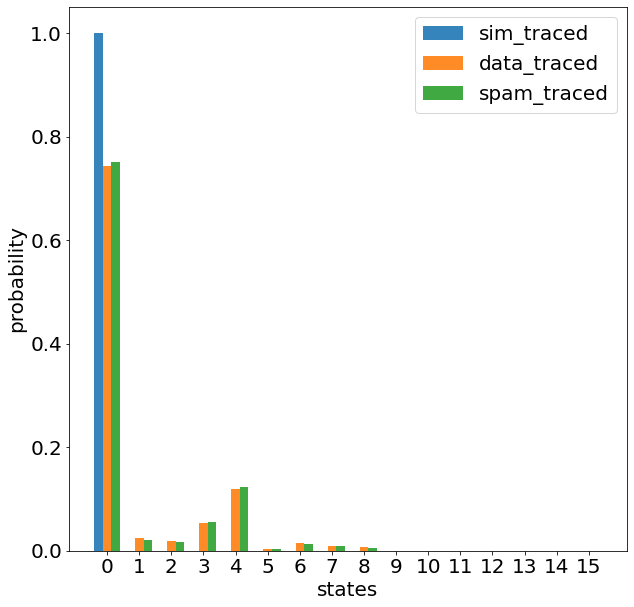

2023-07-03-172227_Line_010.txt
counts: [347, 15, 41, 63, 3144, 103, 127, 129, 1, 0, 0, 0, 26, 2, 2, 0]
counts_ibm_mapping_dic: {'0000': 347, '1000': 15, '0100': 41, '1100': 63, '0010': 3144, '1010': 103, '0110': 127, '1110': 129, '0001': 1, '1001': 0, '0101': 0, '1101': 0, '0011': 26, '1011': 2, '0111': 2, '1111': 0}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:XA230.2500+:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



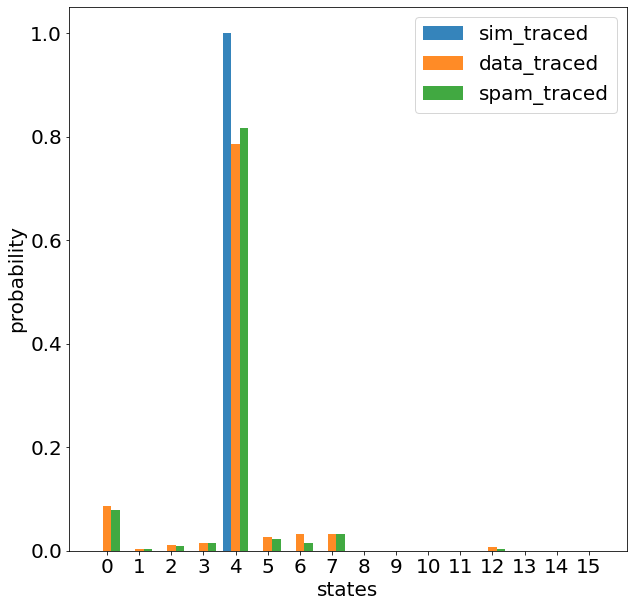

2023-07-03-172304_Line_011.txt
counts: [82, 38, 3394, 127, 70, 20, 231, 19, 0, 0, 18, 0, 0, 0, 1, 0]
counts_ibm_mapping_dic: {'0000': 82, '1000': 38, '0100': 3394, '1100': 127, '0010': 70, '1010': 20, '0110': 231, '1110': 19, '0001': 0, '1001': 0, '0101': 18, '1101': 0, '0011': 0, '1011': 0, '0111': 1, '1111': 0}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



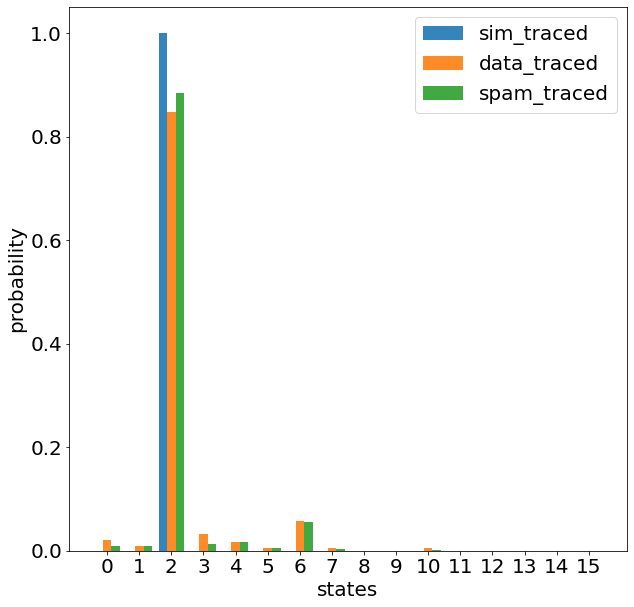

2023-07-03-172342_Line_012.txt
counts: [26, 330, 31, 57, 156, 3175, 19, 169, 0, 3, 0, 0, 1, 31, 1, 1]
counts_ibm_mapping_dic: {'0000': 26, '1000': 330, '0100': 31, '1100': 57, '0010': 156, '1010': 3175, '0110': 19, '1110': 169, '0001': 0, '1001': 3, '0101': 0, '1101': 0, '0011': 1, '1011': 31, '0111': 1, '1111': 1}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



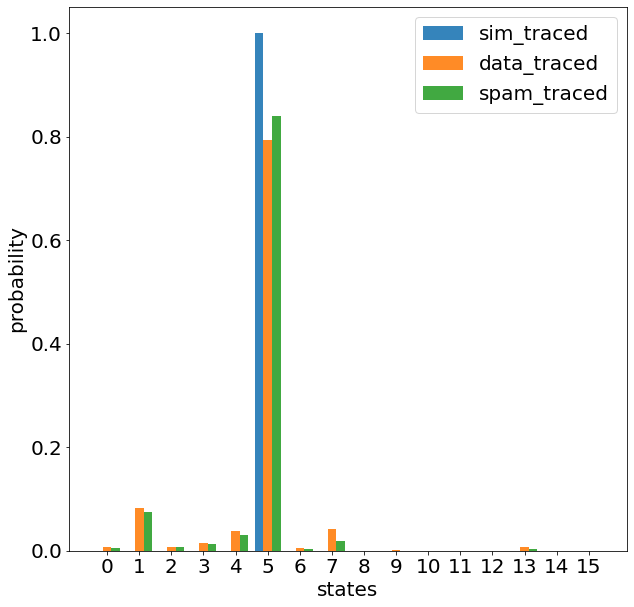

2023-07-03-182415_Line_013.txt
counts: [368, 21, 61, 80, 3130, 94, 120, 113, 0, 0, 1, 0, 11, 0, 1, 0]
counts_ibm_mapping_dic: {'0000': 368, '1000': 21, '0100': 61, '1100': 80, '0010': 3130, '1010': 94, '0110': 120, '1110': 113, '0001': 0, '1001': 0, '0101': 1, '1101': 0, '0011': 11, '1011': 0, '0111': 1, '1111': 0}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



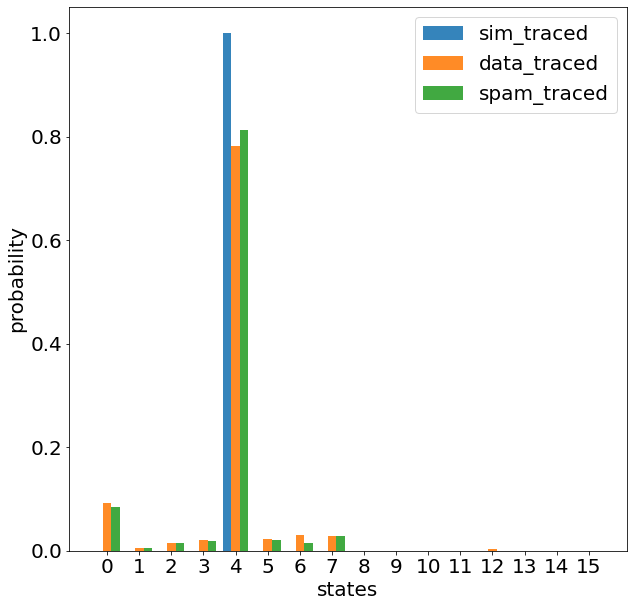

2023-07-03-182452_Line_014.txt
counts: [200, 63, 106, 3237, 30, 120, 21, 205, 1, 0, 0, 15, 1, 0, 0, 1]
counts_ibm_mapping_dic: {'0000': 200, '1000': 63, '0100': 106, '1100': 3237, '0010': 30, '1010': 120, '0110': 21, '1110': 205, '0001': 1, '1001': 0, '0101': 0, '1101': 15, '0011': 1, '1011': 0, '0111': 0, '1111': 1}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



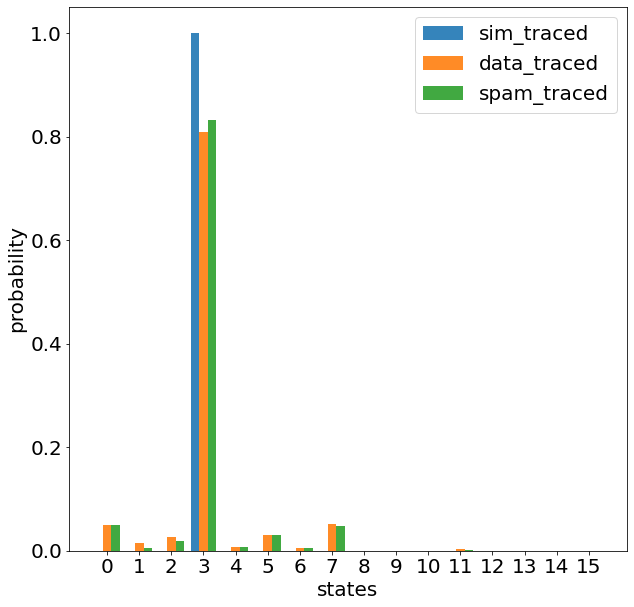

2023-07-03-182529_Line_015.txt
counts: [3212, 121, 51, 8, 454, 26, 69, 18, 31, 4, 0, 0, 5, 0, 1, 0]
counts_ibm_mapping_dic: {'0000': 3212, '1000': 121, '0100': 51, '1100': 8, '0010': 454, '1010': 26, '0110': 69, '1110': 18, '0001': 31, '1001': 4, '0101': 0, '1101': 0, '0011': 5, '1011': 0, '0111': 1, '1111': 0}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



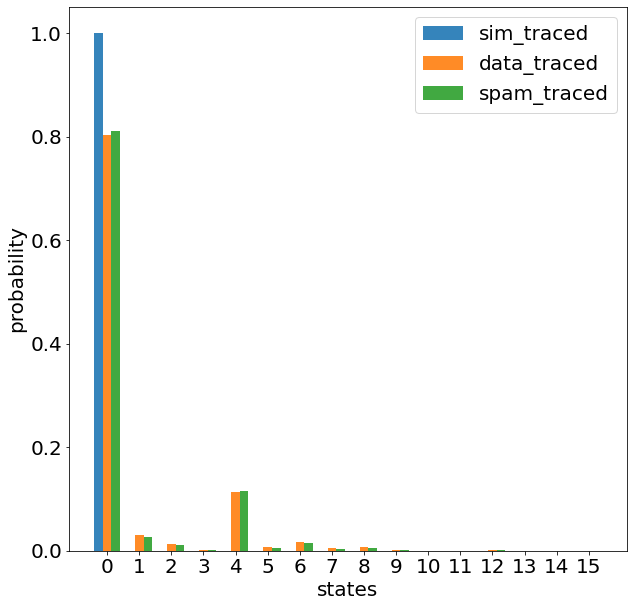

2023-07-03-182606_Line_016.txt
counts: [138, 107, 98, 3221, 69, 138, 22, 175, 2, 1, 1, 25, 0, 1, 0, 2]
counts_ibm_mapping_dic: {'0000': 138, '1000': 107, '0100': 98, '1100': 3221, '0010': 69, '1010': 138, '0110': 22, '1110': 175, '0001': 2, '1001': 1, '0101': 1, '1101': 25, '0011': 0, '1011': 1, '0111': 0, '1111': 2}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



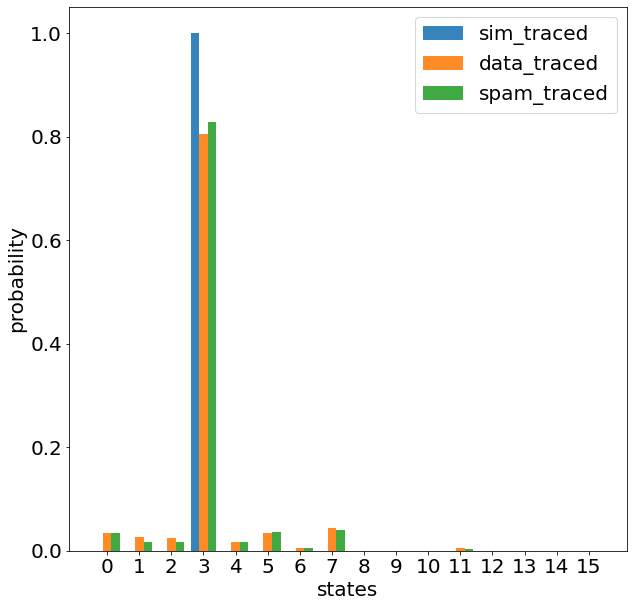

2023-07-03-182803_Line_017.txt
counts: [2868, 109, 84, 206, 584, 38, 47, 28, 27, 4, 0, 2, 3, 0, 0, 0]
counts_ibm_mapping_dic: {'0000': 2868, '1000': 109, '0100': 84, '1100': 206, '0010': 584, '1010': 38, '0110': 47, '1110': 28, '0001': 27, '1001': 4, '0101': 0, '1101': 2, '0011': 3, '1011': 0, '0111': 0, '1111': 0}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



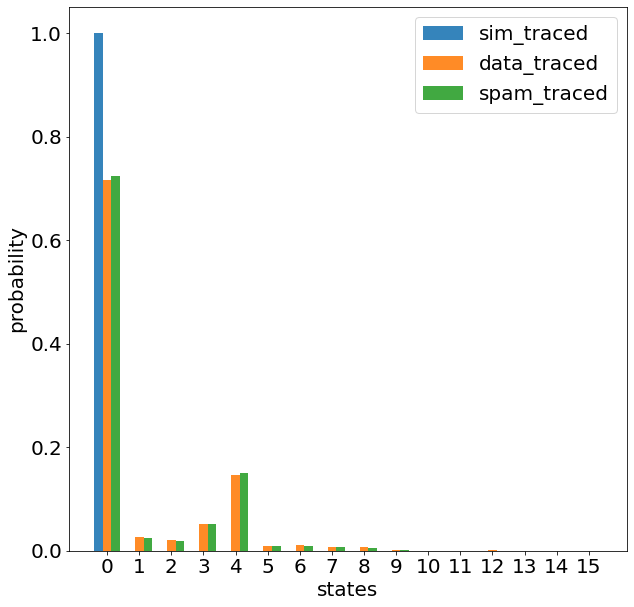

2023-07-03-182840_Line_018.txt
counts: [369, 22, 98, 18, 2864, 136, 225, 256, 1, 0, 0, 0, 9, 0, 0, 2]
counts_ibm_mapping_dic: {'0000': 369, '1000': 22, '0100': 98, '1100': 18, '0010': 2864, '1010': 136, '0110': 225, '1110': 256, '0001': 1, '1001': 0, '0101': 0, '1101': 0, '0011': 9, '1011': 0, '0111': 0, '1111': 2}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



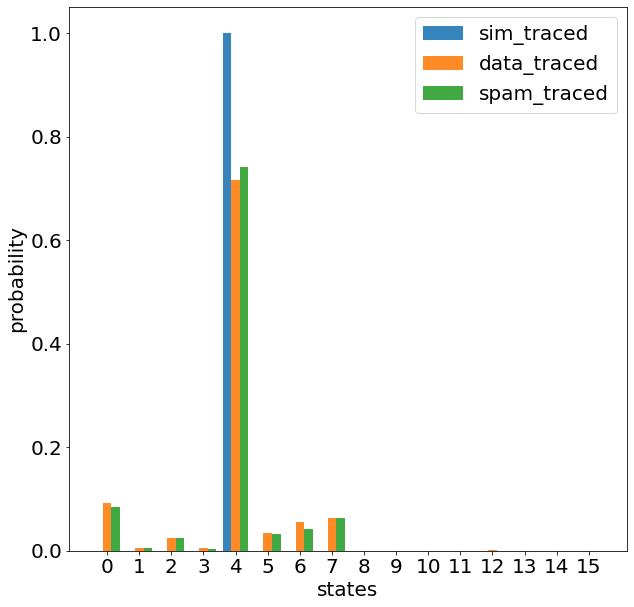

2023-07-03-182917_Line_019.txt
counts: [94, 29, 3531, 124, 56, 25, 117, 6, 0, 0, 17, 1, 0, 0, 0, 0]
counts_ibm_mapping_dic: {'0000': 94, '1000': 29, '0100': 3531, '1100': 124, '0010': 56, '1010': 25, '0110': 117, '1110': 6, '0001': 0, '1001': 0, '0101': 17, '1101': 1, '0011': 0, '1011': 0, '0111': 0, '1111': 0}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



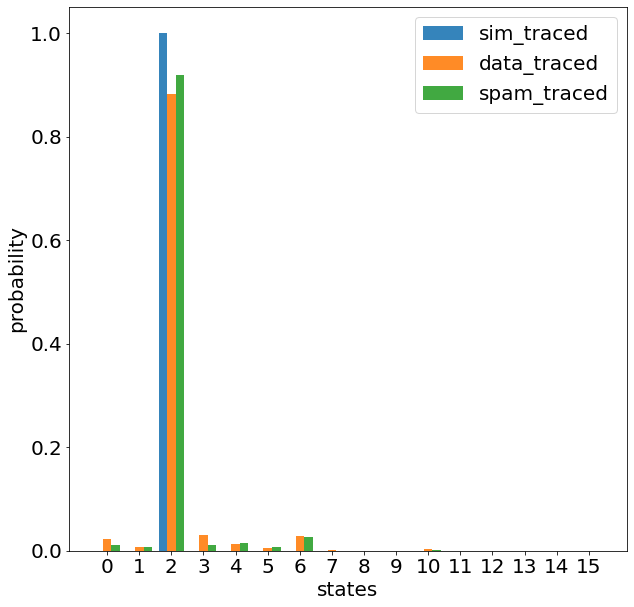

2023-07-03-182954_Line_020.txt
counts: [396, 34, 36, 12, 3199, 145, 109, 40, 1, 0, 1, 0, 24, 3, 0, 0]
counts_ibm_mapping_dic: {'0000': 396, '1000': 34, '0100': 36, '1100': 12, '0010': 3199, '1010': 145, '0110': 109, '1110': 40, '0001': 1, '1001': 0, '0101': 1, '1101': 0, '0011': 24, '1011': 3, '0111': 0, '1111': 0}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



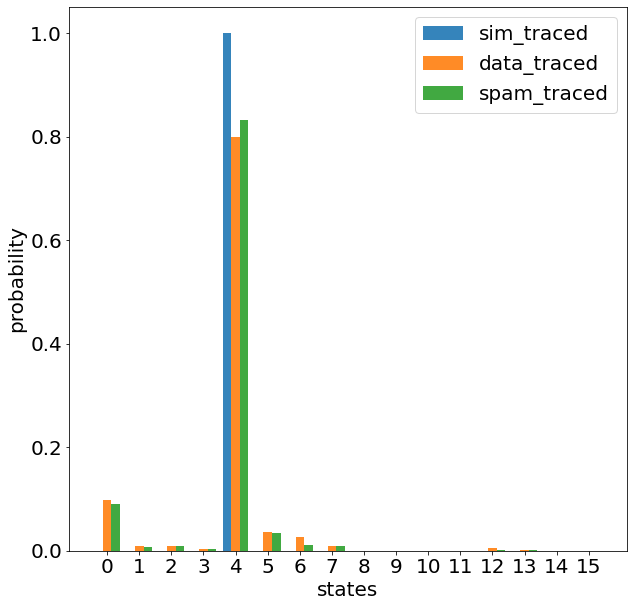

In [31]:
filenames_data=[]
counts_d2=[]
counts_d2_spam=[]
shots=4000
counts=[]
counts_spam=[]
filenames_data=filenames_d2.copy()
# print (filenames_data)
# print (len(filenames_data))
paf_data=paf_data_d2
circuit=c_d2
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    print ("counts:", counts)
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    print ("counts_ibm_mapping_dic:",counts_ibm_mapping_dic)
    counts_d2.append(counts_ibm_mapping_dic)
    
    a_s=spam1.Correct_SPAM(a)
    data_traced_spam=Trace_Out(a_s,[0,1,2,3])
    counts_spam=[round(shots*x) for x in  data_traced_spam.population]
    counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
    counts_d2_spam.append(counts_ibm_mapping_dic_spam)

    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=2","spam"])
    Display_States_Population(states=[sim_traced,data_traced,data_traced_spam],label=["sim_traced","data_traced","spam_traced"])
# #         

['2023-07-03-184452_Line_001.txt', '2023-07-03-184534_Line_002.txt', '2023-07-03-184617_Line_003.txt', '2023-07-03-184819_Line_004.txt', '2023-07-03-184900_Line_005.txt', '2023-07-03-184942_Line_006.txt', '2023-07-03-185144_Line_007.txt', '2023-07-03-185226_Line_008.txt', '2023-07-03-185308_Line_009.txt', '2023-07-03-192339_Line_010.txt', '2023-07-03-192423_Line_011.txt']
2023-07-03-184452_Line_001.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



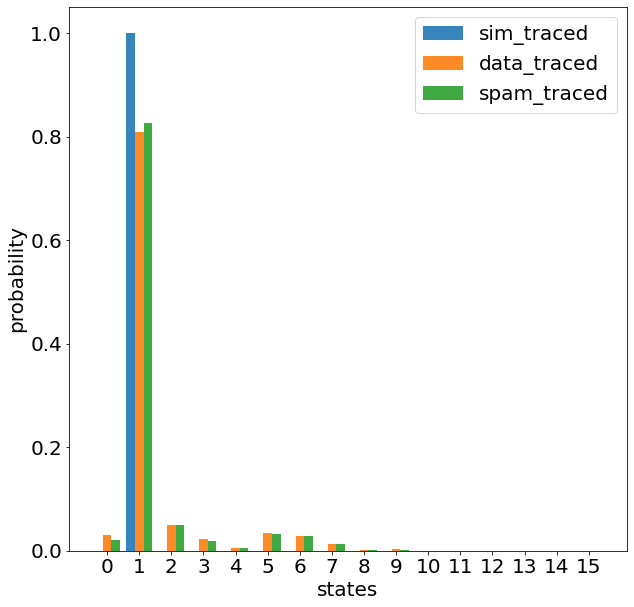

2023-07-03-184534_Line_002.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



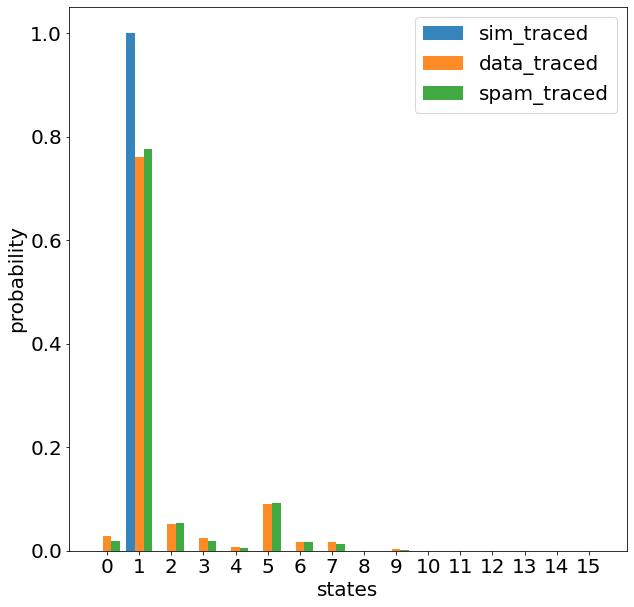

2023-07-03-184617_Line_003.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



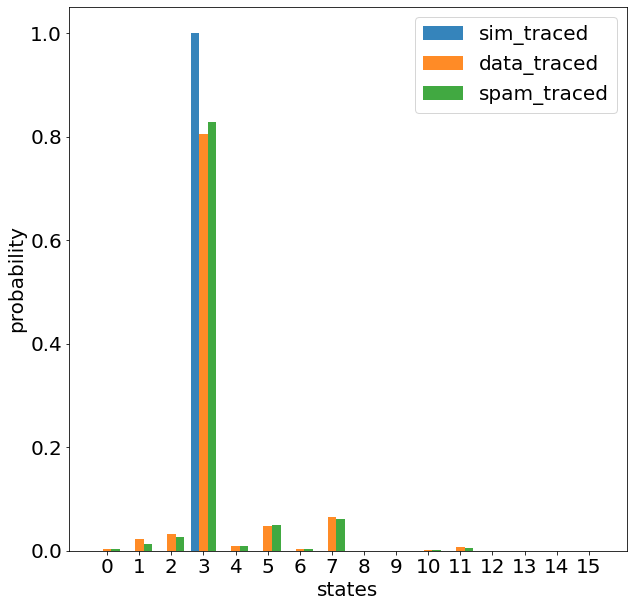

2023-07-03-184819_Line_004.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



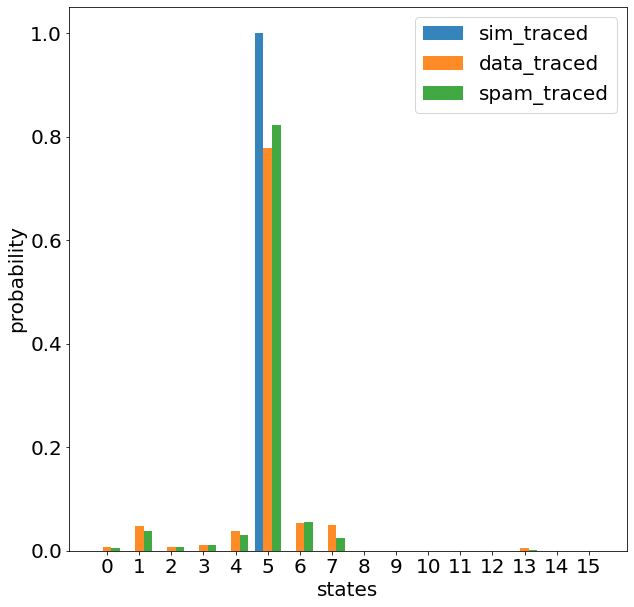

2023-07-03-184900_Line_005.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



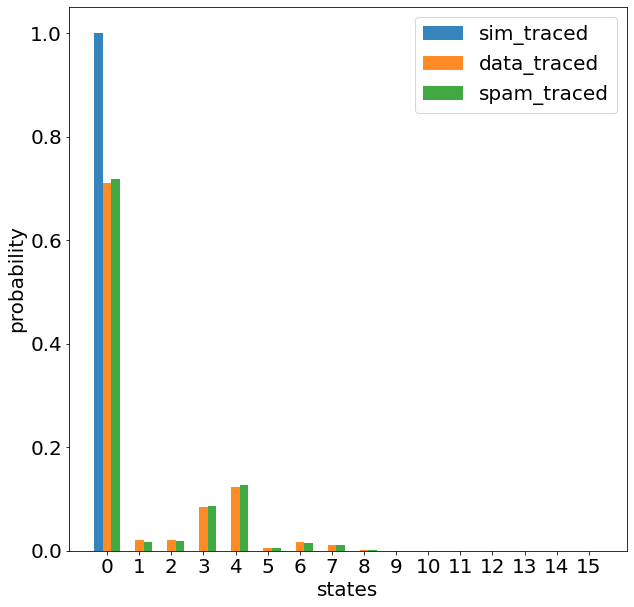

2023-07-03-184942_Line_006.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:XA230.2500+:XA230.2500+:RX+31:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



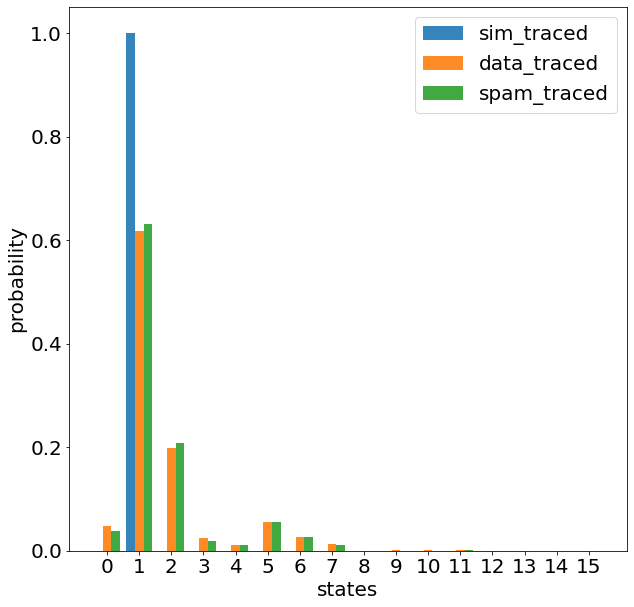

2023-07-03-185144_Line_007.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



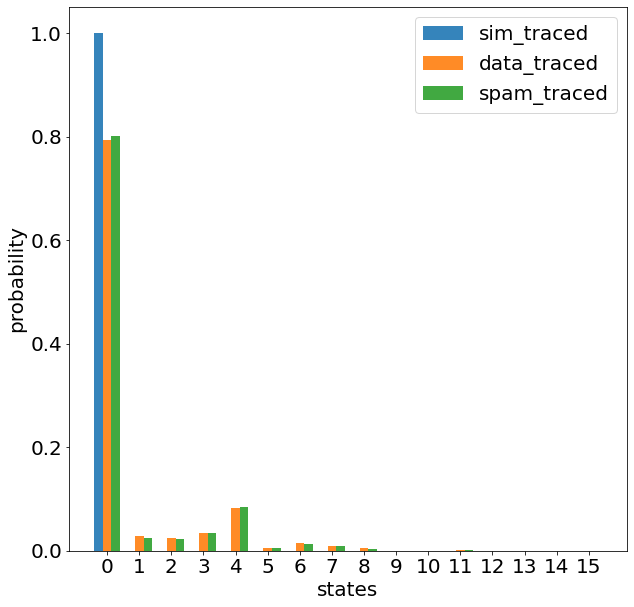

2023-07-03-185226_Line_008.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



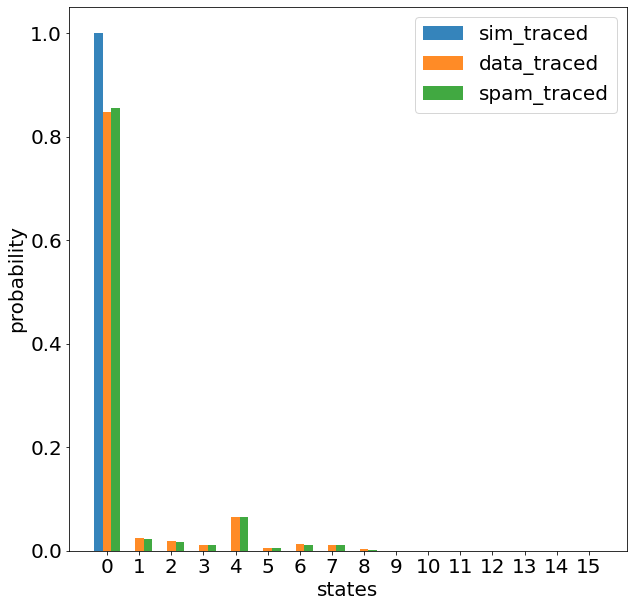

2023-07-03-185308_Line_009.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+31:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



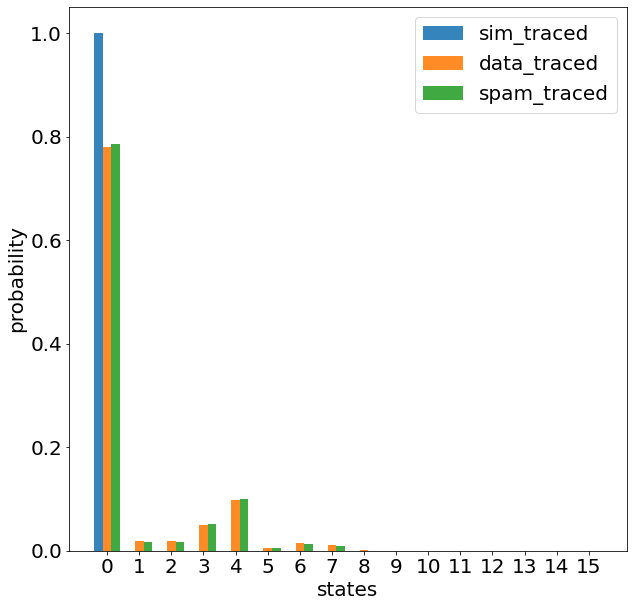

2023-07-03-192339_Line_010.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



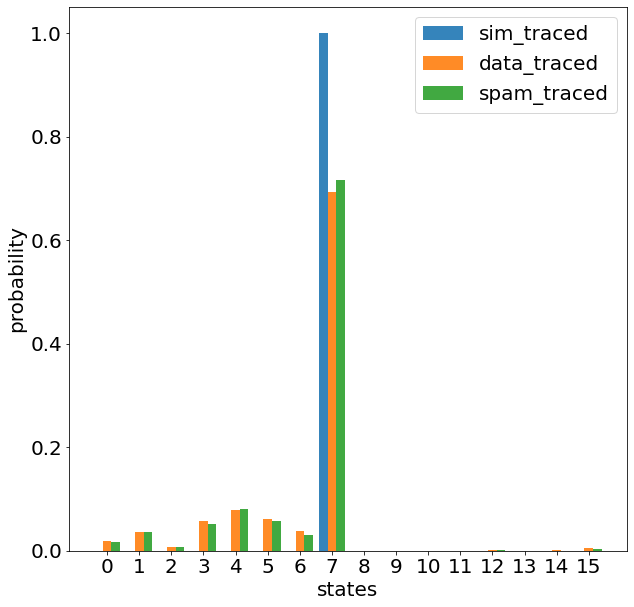

2023-07-03-192423_Line_011.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



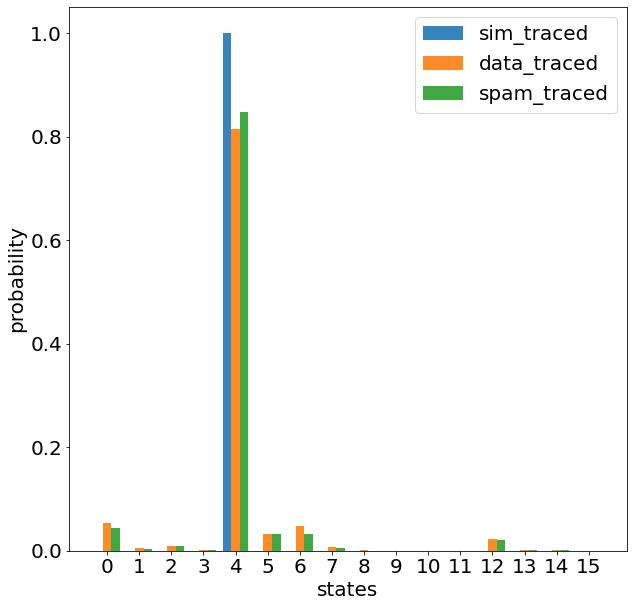

In [32]:
filenames_data=[]
counts_d4=[]
counts_d4_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d4.copy()
print (filenames_data)
# print (len(filenames_data))
paf_data=paf_data_d4
circuit=c_d4
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d4.append(counts_ibm_mapping_dic)
    
    
    a_s=spam1.Correct_SPAM(a)
    data_traced_spam=Trace_Out(a_s,[0,1,2,3])
    counts_spam=[round(shots*x) for x in  data_traced_spam.population]
    counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
    counts_d4_spam.append(counts_ibm_mapping_dic_spam)

    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=4","spam"])
    Display_States_Population(states=[sim_traced,data_traced,data_traced_spam],label=["sim_traced","data_traced","spam_traced"])
# #         

2023-07-03-195217_Line_001.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



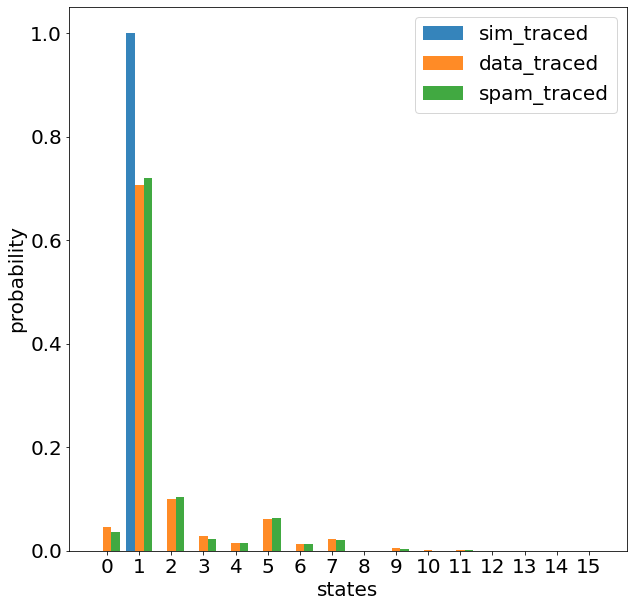

2023-07-03-195310_Line_002.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



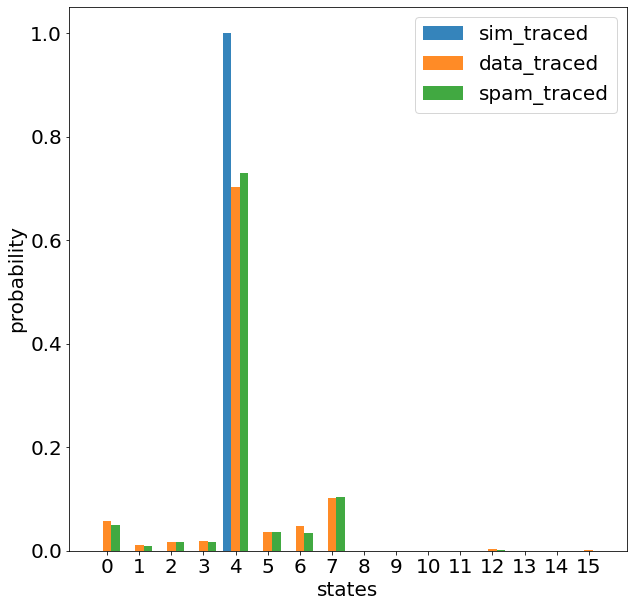

2023-07-03-195523_Line_003.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



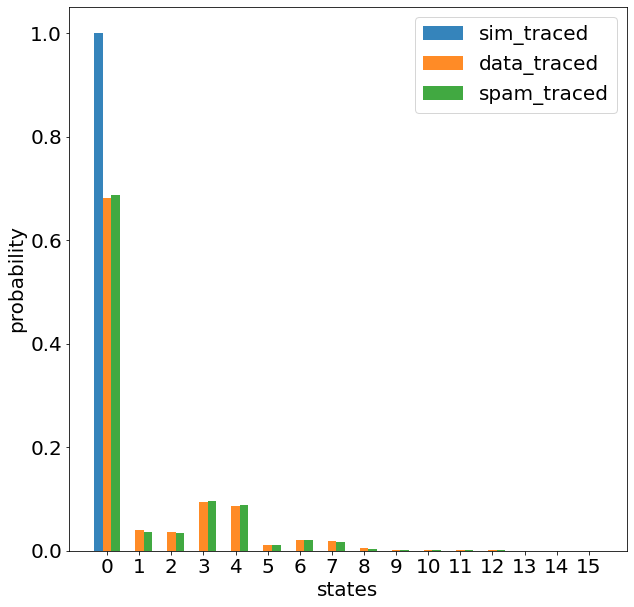

In [36]:
filenames_data=[]
counts_d8=[]
counts_d8_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d8.copy()
# print (filenames_data)
# # print (len(filenames_data))
paf_data=paf_data_d8
circuit=c_d8
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d8.append(counts_ibm_mapping_dic)
    
    a_s=spam1.Correct_SPAM(a)
    data_traced_spam=Trace_Out(a_s,[0,1,2,3])
    counts_spam=[round(shots*x) for x in  data_traced_spam.population]
    counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
    counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
    Display_States_Population(states=[sim_traced,data_traced,data_traced_spam],label=["sim_traced","data_traced","spam_traced"])

In [12]:
# print (counts_d2[0])
# print (counts_d2_spam[0])

In [13]:
import copy
from copy import copy, deepcopy

# copy.copy(x)
# copy.deepcopy(x)

# picklefile="c39b72eb-9de9-4338-b6ae-e478130a3f4fXX23541withpadding_set2"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/0516/13452 0516 FT explicit CNOT R rotations auto/9c845ecd-7110-4fa0-bea0-9287796dc4e5XX13452noS_explicitCNOT_FT_Rrotations0516", "rb") as fp:   # Unpickling
    eab_load = pickle.load(fp)
# print (picklefile)
# print (b)

# with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/23541 EAB XX C=10 0424 /"+picklefile, "rb") as fp:   # Unpickling
#     eab_load_2 = pickle.load(fp)
# print (picklefile)

# with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/23541 EAB XX C=10 0424 /"+picklefile, "rb") as fp:   # Unpickling
#     eab_load_3 = pickle.load(fp)
# print (picklefile)


C=20
eab_load_cpy=deepcopy(eab_load[0:60])
eab_load_cpy_spam=deepcopy(eab_load[0:60])
# eab_load_cpy_24=deepcopy(eab_load[0:20]) #a copy that only has depth=[2,4]


In [14]:
for i in range (C):
#     print (i)
    assert eab_load_cpy[i]["L"]==2
    eab_load_cpy[i]["counts"]=counts_d2[i].copy()


    
for i in range (C):
#     print (i)
    assert eab_load_cpy_spam[i]["L"]==2
    eab_load_cpy_spam[i]["counts"]=counts_d2_spam[i].copy()



# for i in range (C):
#     print (eab_load_cpy[i]["counts"])
#     print (eab_load_cpy_spam[i]["counts"])

In [15]:
for i in range (C,2*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==4
    eab_load_cpy[i]["counts"]=counts_d4[i-C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i]["counts"])
    
for i in range (C,2*C):
#     print (i)
    assert eab_load_cpy_spam[i]["L"]==4
    eab_load_cpy_spam[i]["counts"]=counts_d4_spam[i-C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy_spam[i]["counts"])

# for i in range (C,2*C):
#     print (eab_load_cpy[i]["counts"])
#     print (eab_load_cpy_spam[i]["counts"])    

In [16]:
for i in range (2*C,3*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==8
    eab_load_cpy[i]["counts"]=counts_d8[i-2*C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i])

for i in range (2*C,3*C):
#     print (i)
    assert eab_load_cpy_spam[i]["L"]==8
    eab_load_cpy_spam[i]["counts"]=counts_d8_spam[i-2*C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy_spam[i]["counts"])

# for i in range (2*C,3*C):
#     print (eab_load_cpy[i]["counts"])
#     print (eab_load_cpy_spam[i]["counts"])    

In [17]:
# print (eab_load_cpy)

In [18]:
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation")
import EAB_process_modified 
import itertools
import pdb

'''Specify a set of Pauli you want to estimate'''
# C=10
C=20
nqubit=2
depth=[2,4,8]
pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = nqubit)] #full

#process_EAB(Lrange, cb_data, pauli_request_list)
eab_result=EAB_process_modified.process_EAB(depth, eab_load_cpy_spam, pauli_request_list)
# eab_result_spam=EAB_process_modified.process_EAB(depth, eab_load_cpy_spam, pauli_request_list)

print (eab_result)


{'fidelity_list': {'II': {2: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 8: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, 'IX': {2: [0.837, 0.7459364841210303, 0.7555611097225694, 0.7584396099024756, 0.7695, 0.664, 0.7915, 0.7524381095273819, 0.8175, 0.7970507373156711, 0.746436609152288, 0.7915, 0.6875, 0.8239559889972493, 0.7646176911544228, 0.7061469265367316, 0.8270432391902024, 0.7262947210407806, 0.7555611097225694, 0.7986006996501749], 4: [0.7739434858714679, 0.689344672336168, 0.689, 0.6745813546613346, 0.679, 0.7583791895947974, 0.6953476738369184, 0.6690827293176705, 0.6865783554111472, 0.7035741064733817, 0.7105, 0.7305673581604599, 0.7064266066516629, 0.7140714821294676, 0.6545, 0.6754188547136785, 0.6555, 0.7300674831292177, 0.792448112028007, 0.71042760690

In [19]:
from scipy.optimize import curve_fit
def rcs_fit_fun_depth1(x, alpha):
        #return a * np.exp(-alpha * x)
        return alpha ** x

def fit_EAB_depth1(X, xeb_list):
    Y = [np.mean(xeb_list[L]) for L in X]
    Yerr = [sem(xeb_list[L]) for L in X]
    #print(linregress(X,np.log(Y)))
    
    
    try:
        params, pcov = curve_fit(rcs_fit_fun_depth1, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1])
        alpha = params[0]
        params_err = np.sqrt(np.diag(pcov))
        alpha_err = params_err[0]

    except RuntimeError:
        alpha = 1.0
        alpha_err = 0.0


    return alpha, alpha_err

    print(alpha, alpha_err)

In [20]:
raw_fidelity_list = eab_result["fidelity_list"]

#######depth=[2]#########
##########################
plot_dic={}
error_dic={}
err=[]
# sys.exit(0)
depth=[2]
fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = fit_EAB_depth1(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=4000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

plot_2={}
plot_2=deepcopy(plot_dic)
err_2=deepcopy(error_dic)

#######depth=[2]#########
##########################
plot_dic={}
err=[]
# sys.exit(0)
depth=[2,4]
fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=4000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

plot_24={}
plot_24=deepcopy(plot_dic)
err_24=deepcopy(error_dic)

#######depth=[2]#########
##########################
plot_dic={}
error_dic={}
error_dic={}
err=[]
# sys.exit(0)
depth=[2,4,8]
fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=4000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

plot_248={}
plot_248=deepcopy(plot_dic)
err_248=deepcopy(error_dic)


Parameters: n = 2, C = 20,  L =  [2]
Measurement based simulation, shots = 4000
No readout error
Total error =  0.1303317885813906
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.12488334960322156 0.005941204666987092
YI 0.1463136123414901 0.006421816251803404
ZI 0.04847313271969467 0.002166435331755994
IX 0.09773455789432539 0.00910720510302617
XX 0.20281086917378333 0.008767098974213718
YX 0.2140543058968989 0.009003721205990514
ZX 0.12998010880163013 0.009254665466758103
IY 0.12120280340840683 0.009682582419600913
XY 0.21389513477959432 0.008398951478361165
YY 0.23041479900632866 0.008492341495922033
ZY 0.13951505166838907 0.008472809848438907
IZ 0.041484458712132466 0.001876394499928424
XZ 0.1486895187961581 0.005674137221186369
YZ 0.16604491538911936 0.0061301119132051865
ZZ 0.05981199911107693 0.0019755762365745964
Parameters: n = 2, C = 20,  L =  [2, 4]
Measurement based simulation, shots = 4000
No readout error
Total error =  0.04268582516246222
Label / Pauli infi

In [21]:
def rcs_fit_fun(x, a, alpha):
        #return a * np.exp(-alpha * x)
        return a * (alpha ** x)

def fit_EAB_plot(X, xeb_list):
    Y = [np.mean(xeb_list[L]) for L in X]
    Yerr = [sem(xeb_list[L]) for L in X]
    #print(linregress(X,np.log(Y)))
    
    
    try:
        params, pcov = curve_fit(rcs_fit_fun, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1,1])
        alpha = params[1]
        a=params[0]
        params_err = np.sqrt(np.diag(pcov))
        alpha_err = params_err[1]

    except RuntimeError:
        alpha = 1.0
        alpha_err = 0.0

    # params, pcov = curve_fit(rcs_fit_fun, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1,1])
    # #params, pcov = curve_fit(rcs_fit_fun, X, Y, absolute_sigma=True, p0=[1,1])


    # print(params)

    return alpha,a, alpha_err,Y, Yerr

    print(alpha, alpha_err)




Parameters: n = 2, C = 20,  L =  [2, 4, 8]
Measurement based simulation, shots = 4000
No readout error
Total error =  0.07076750270037246
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.07665268499158029 0.004888904713942495
YI 0.08237806127330527 0.0053268274579203875
ZI 0.01853019234203601 0.0018453106920147777
IX 0.0672386793574673 0.00677982361109328
XX 0.12344508144783584 0.009156932871123484
YX 0.1110884481709129 0.008720463114820035
ZX 0.06988841782398603 0.0076420965378719095
IY 0.07010124191081768 0.0074609784568191225
XY 0.11666998018556574 0.008233978636486498
YY 0.12119331436000147 0.00920059479694727
ZY 0.07182955922656031 0.007496766141492332
IZ 0.02242422331534344 0.002190028759810742
XZ 0.08649967965789773 0.0052373867633128905
YZ 0.08261807182331427 0.0051541508370624095
ZZ 0.011722407319335826 0.0020289785493457784
{'IX': [0.7658291518016773, 0.7049379535608553, 0.44539448956126987], 'IY': [0.7287804484734356, 0.6642322190300941, 0.41842458620644585], 'I

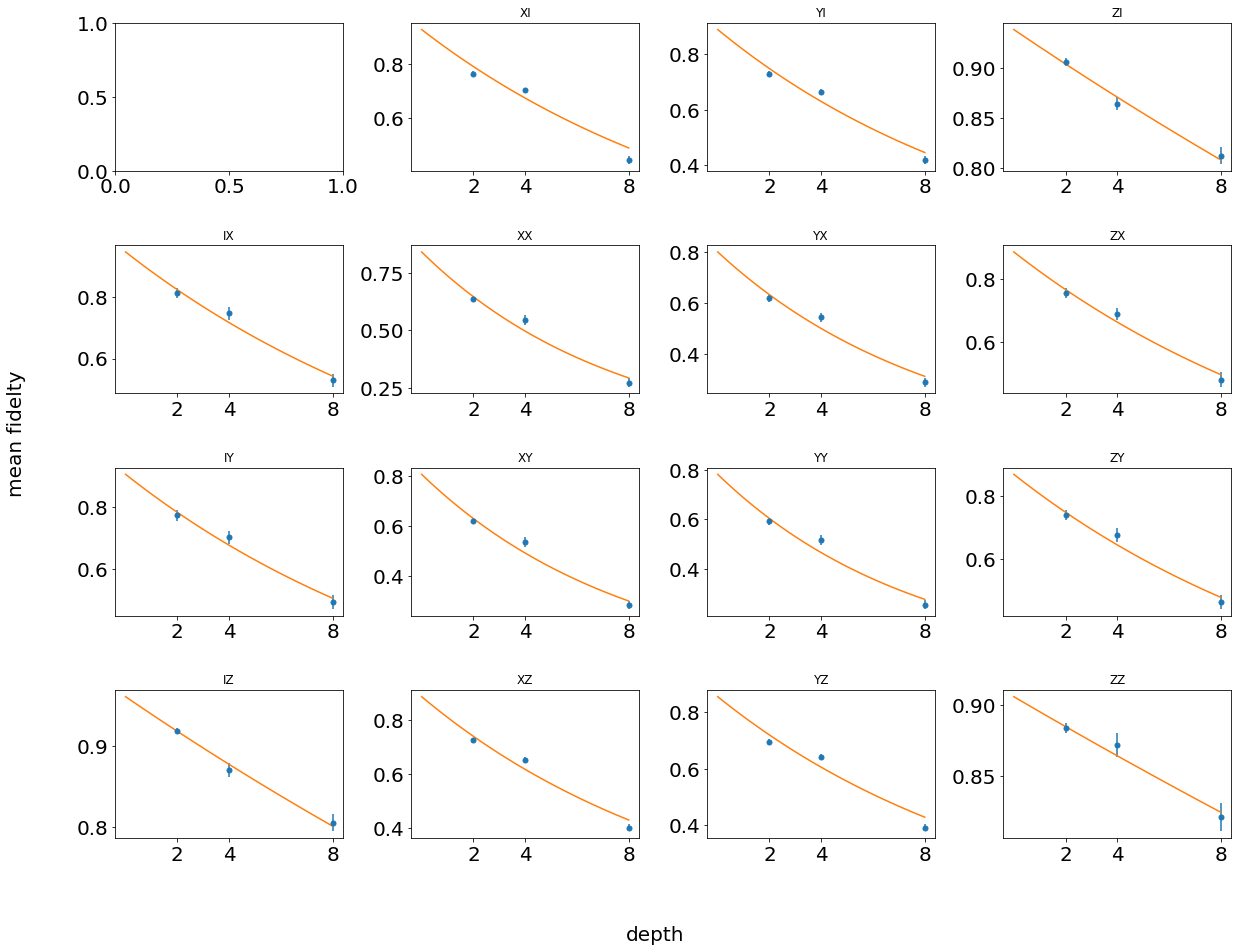

In [24]:
raw_fidelity_list = eab_result["fidelity_list"]
plot_dic={}
error_dic={}
# sys.exit(0)
depth=[2,4,8]
fidelity_list = {}
stdev_list = {}
a248_dic={}
Y248_dic={}
Yerr248_dic={}
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha,a, alpha_err,Y, Yerr = fit_EAB_plot(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha #pauli fidelity from fit
        stdev_list[pauli_label] = alpha_err #error on pauli fidelity from fit
        a248_dic[pauli_label]=a 
        Y248_dic[pauli_label]=Y
        Yerr248_dic[pauli_label]=Yerr

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=4000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
# for pauli_label in pauli_request_list:
#     print(pauli_label[::-1], fidelity_list[pauli_label])

plot_248={}
plot_248=deepcopy(plot_dic)
err_248=deepcopy(error_dic)
print (Y248_dic)

x_c=np.linspace(0,8,num=80)
nqubit=2
fig, axs = plt.subplots(4, 4)
fig.set_figwidth(20)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (4):
    for j in range(4):
        pauli_label=pauli_request_list[4*i+j]
        if (pauli_label == 'I'*nqubit):
#                 fidelity_list[pauli_label] = 1.0
#                 stdev_list[pauli_label] = 0.0
            pass
        else:
            axs[i, j].set_xticks([2,4,8])   
            axs[i, j].errorbar(depth,Y248_dic[pauli_label], yerr=Yerr248_dic[pauli_label], fmt='o',markersize=5)
            axs[i, j].plot(x_c,rcs_fit_fun(x_c,a248_dic[pauli_label], fidelity_list[pauli_label]))
            axs[i, j].set_title(pauli_label[::-1])
                
# for pauli_label in pauli_request_list:
# fig.savefig("fit.pdf", format="pdf", dpi=500)        

In [23]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], error_list[pauli_label])


Label / Pauli error rates
II 0.9292324972996274
XI 0.00038855634205900436
YI 0.0011372476739772153
ZI 0.029300662538429202
IX 0.002114807024482121
XX 0.0014300278846105796
YX 0.002339150801491871
ZX 0.0004377107565889521
IY 0.0010981234141391877
XY 0.0034248461721834156
YY 0.00011397722622502604
ZY 0.00025346837795066357
IZ 0.023164337610020888
XZ 0.0008204617570872069
YZ -0.0003891716866163547
ZZ 0.005133296807743604


spam results